# Libraries

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



import nltk.metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ilay2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

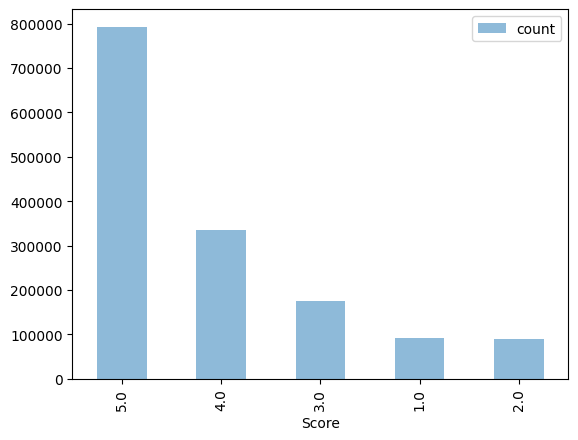


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
def calculate_sentiment(text):
    #Returns a dictionary with pos, neu, neg, and compound scores
    if isinstance(text, str):  #Type checking: Process only if the text is a string
        sentiment = sia.polarity_scores(text)
        return sentiment['compound']
    else:
        return 0

In [5]:
def calculate_user_features(df):
    #Calculate user statistics
    user_stats = df.groupby('UserId').agg({
        'Score': ['mean', 'std', 'count']
    }).reset_index()
    
    #Flatten column names
    user_stats.columns = ['UserId', 'User_Avg_Score', 'User_Score_Variation', 'User_Review_Count']
    
    #Fill nan values in std with 0 (for users with only one review)
    user_stats['User_Score_Variation'] = user_stats['User_Score_Variation'].fillna(0)
    
    #Merge these statistics back to the original dataframe
    df = df.merge(user_stats, on='UserId', how='left')
    
    return df

In [15]:
def add_features_to(df, training_scores=None):
    #Helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['Helpfulness_Dif'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']

    #Avg review length by score
    df['Review_Length'] = df['Text'].str.len()
    df['Review_Length'] = df['Review_Length'].fillna(0)

    #Language learning of positive/negative language
    df['Sentiment_Score'] = df['Text'].apply(calculate_sentiment)
    df['Summary_Sentiment_Score'] = df['Summary'].apply(calculate_sentiment)

    #Avg score per product id
    if training_scores is None:
        #Avg score for each product ID
        training_scores = df.groupby('ProductId')['Score'].mean()
    #Insert avg score for each product in a row which corresponds to its product
    df['Product_Avg_Score'] = df['ProductId'].map(training_scores)

    #Get user features
    df = calculate_user_features(df)
    df['User_Avg_Score'] = df['User_Avg_Score'].fillna(df['User_Avg_Score'].mean())
    df['User_Score_Variation'] = df['User_Score_Variation'].fillna(df['User_Score_Variation'].mean())
    df['User_Review_Count'] = df['User_Review_Count'].fillna(1)

    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    train = pd.read_csv("./data/X_train.csv")
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

FEATURE PLOTTING

In [7]:
if 'Score' not in X_train.columns:
    print("Warning: 'Score' column is missing in X_train.")
print("Columns in X_train:", X_train.columns)

Columns in X_train: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Helpfulness_Dif', 'Review_Length', 'Sentiment_Score',
       'Summary_Sentiment_Score', 'Product_Avg_Score', 'User_Avg_Score',
       'User_Score_Variation', 'User_Review_Count'],
      dtype='object')


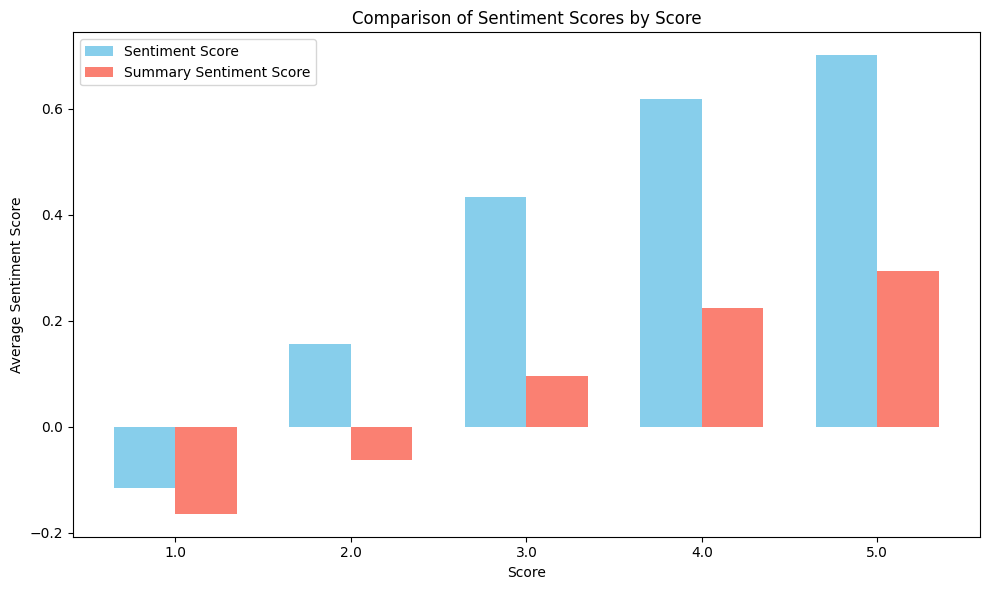

In [8]:
#Calculate the mean sentiment scores grouped by 'Score'
sentiment_score_mean = train.groupby('Score')['Sentiment_Score'].mean()
summary_sentiment_score_mean = train.groupby('Score')['Summary_Sentiment_Score'].mean()

#Align by index (Score values)
scores = sentiment_score_mean.index


bar_width = 0.35
index = np.arange(len(scores))


fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, sentiment_score_mean.values, bar_width, label='Sentiment Score', color='skyblue')
bars2 = ax.bar(index + bar_width, summary_sentiment_score_mean.values, bar_width, label='Summary Sentiment Score', color='salmon')

ax.set_xlabel('Score')
ax.set_ylabel('Average Sentiment Score')
ax.set_title('Comparison of Sentiment Scores by Score')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(scores)
ax.legend()

plt.tight_layout()
plt.show()


Score
1.0     863.764876
2.0    1122.034501
3.0    1122.100834
4.0    1102.115375
5.0     785.957753
Name: Review_Length, dtype: float64


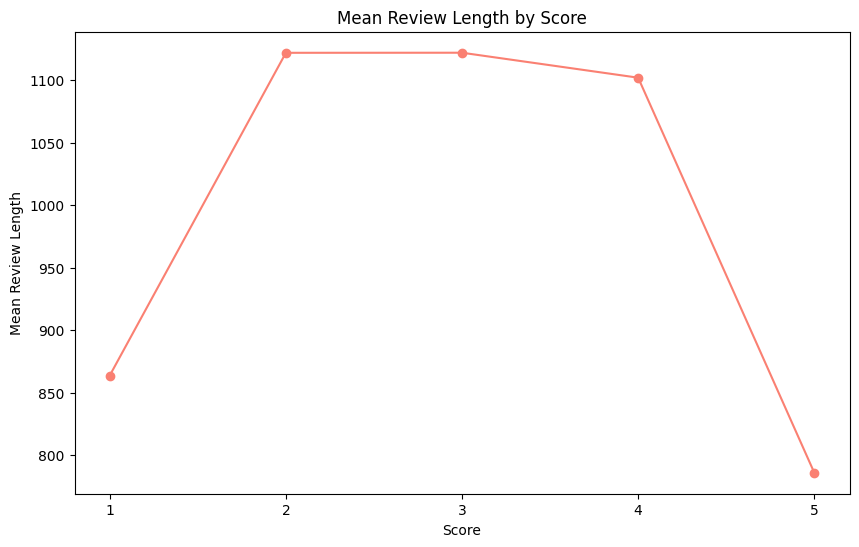

In [9]:
review_length_mean = train.groupby('Score')['Review_Length'].mean()
print(train.groupby('Score')['Review_Length'].mean())
#Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(review_length_mean.index, review_length_mean.values, marker='o', linestyle='-', color='salmon')
plt.xlabel('Score')
plt.ylabel('Mean Review Length')
plt.title('Mean Review Length by Score')
plt.xticks(review_length_mean.index)
plt.show()


Score
1.0    0.362576
2.0    0.365012
3.0    0.370858
4.0    0.432851
5.0    0.400386
Name: Helpfulness, dtype: float64
Score
1.0    9.761619
2.0    4.214244
3.0    1.971070
4.0    0.928479
5.0    0.817036
Name: Helpfulness_Dif, dtype: float64


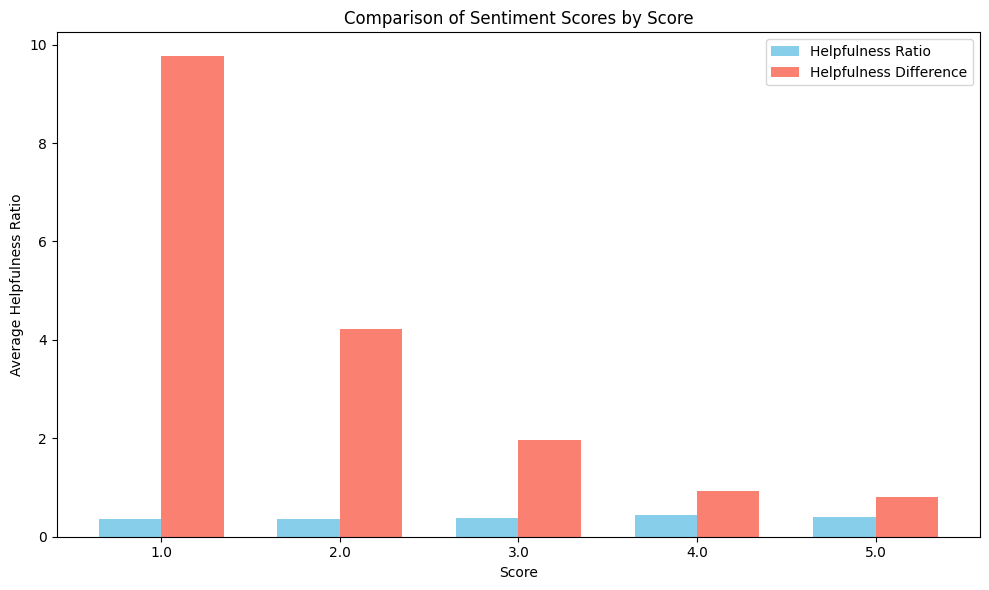

In [10]:
helpfulness_mean = train.groupby('Score')['Helpfulness'].mean()
helpfulness_dif_mean = train.groupby('Score')['Helpfulness_Dif'].mean()
print(helpfulness_mean)
print(helpfulness_dif_mean)

#Align by index (Score values)
scores = helpfulness_mean.index

bar_width = 0.35
index = np.arange(len(scores))

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, helpfulness_mean.values, bar_width, label='Helpfulness Ratio', color='skyblue')
bars2 = ax.bar(index + bar_width, helpfulness_dif_mean.values, bar_width, label='Helpfulness Difference', color='salmon')

ax.set_xlabel('Score')
ax.set_ylabel('Average Helpfulness Ratio')
ax.set_title('Comparison of Sentiment Scores by Score')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(scores)
ax.legend()

plt.tight_layout()
plt.show()


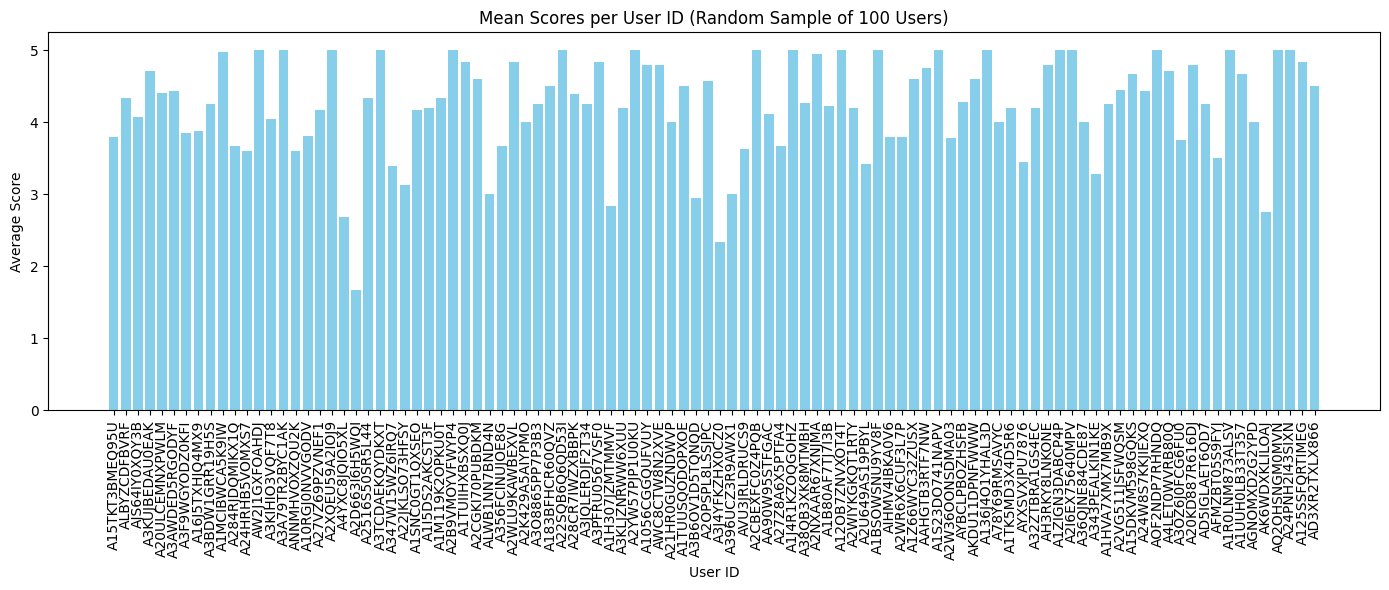

In [11]:
#Randomly sample 100 users
sample_users = X_train['UserId'].drop_duplicates().sample(100, random_state=0)
sample_data = X_train[X_train['UserId'].isin(sample_users)]

#Get their avg score
plt.figure(figsize=(14, 6))
plt.bar(sample_data['UserId'], sample_data['User_Avg_Score'], color='skyblue')

plt.title('Mean Scores per User ID (Random Sample of 100 Users)')
plt.xlabel('User ID')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

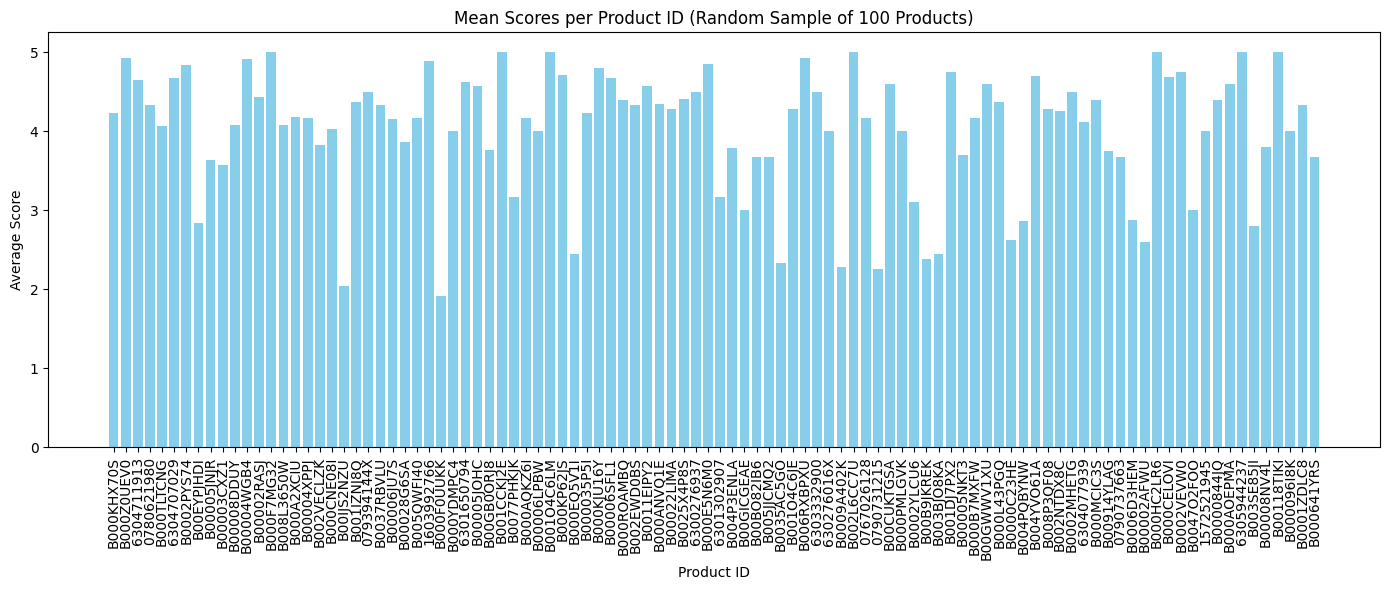

In [20]:
#Randomly sample 100 Products
sample_products = X_train['ProductId'].drop_duplicates().sample(100, random_state=0)
sample_data = X_train[X_train['ProductId'].isin(sample_products)]

#Get their avg score
plt.figure(figsize=(14, 6))
plt.bar(sample_data['ProductId'], sample_data['Product_Avg_Score'], color='skyblue')

plt.title('Mean Scores per Product ID (Random Sample of 100 Products)')
plt.xlabel('Product ID')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# Sample + Split into training and testing set

In [16]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=(1/4.0),
    random_state=0
)

# Feature Selection

In [17]:
features = ['Sentiment_Score', 'Summary_Sentiment_Score', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Helpfulness', 'Review_Length', 'Product_Avg_Score', 'User_Avg_Score', 'User_Review_Count', 'User_Score_Variation', 'Helpfulness_Dif']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [21]:
#Try learning Model with Random forest
model = RandomForestClassifier(n_estimators=150, max_depth=20, random_state=0)
model.fit(X_train_select, Y_train)
#.feature_importance to show important features
print(model.feature_importances_)
# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

[0.09295529 0.08823146 0.02187235 0.032272   0.03034991 0.0700318
 0.16388631 0.21699802 0.05279384 0.17343858 0.05717042]


# Model Evaluation

Accuracy on testing set =  0.6718147445978844


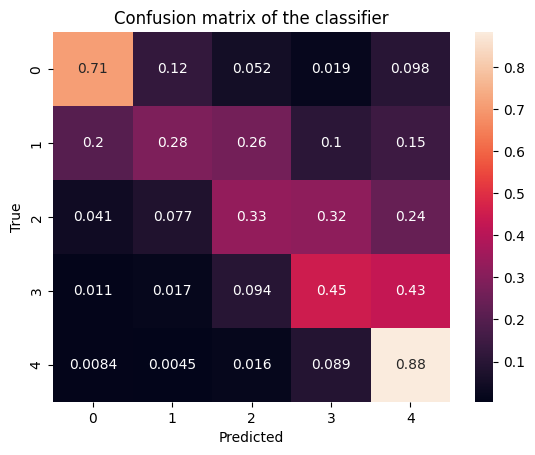

In [22]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

IMPORTANT FEATURES FOR MODEL

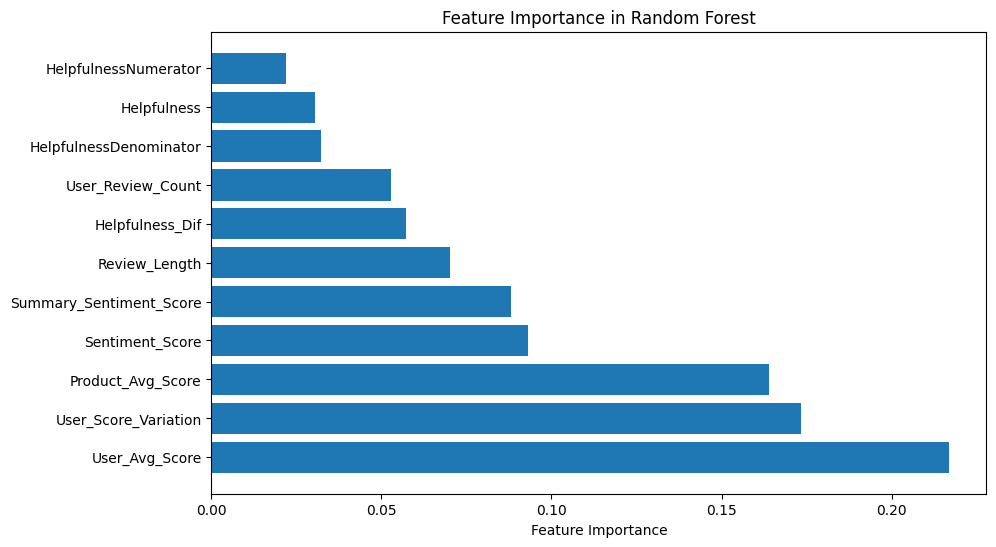

In [23]:
feature_importances = model.feature_importances_
feature_names = X_train_select.columns  # if using a DataFrame
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort features by importance

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

# Create submission file

In [32]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)